In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
from datasets import load_dataset

# Load MNIST-M dataset
ds = load_dataset("Mike0307/MNIST-M")
train_data = ds['train']
test_data = ds['test']

X_train_m = np.array([np.array(image.resize((28, 28))) for image in train_data['image']])
y_train_m = np.array(train_data['label'])
X_test_m = np.array([np.array(image.resize((28, 28))) for image in test_data['image']])
y_test_m = np.array(test_data['label'])

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess MNIST
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train = np.repeat(X_train, 3, axis=-1)  # Convert to 3 channels
X_test = np.repeat(X_test, 3, axis=-1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Preprocess MNIST-M
X_train_m = X_train_m.astype(np.float32)/255
X_test_m = X_test_m.astype(np.float32)/255
y_train_m = to_categorical(y_train_m)
y_test_m = to_categorical(y_test_m)

print('MNIST shapes:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print('MNIST-M shapes:', X_train_m.shape, y_train_m.shape, X_test_m.shape, y_test_m.shape)

c:\Users\anshb\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MNIST shapes: (60000, 28, 28, 3) (60000, 10) (10000, 28, 28, 3) (10000, 10)
MNIST-M shapes: (59001, 28, 28, 3) (59001, 10) (9001, 28, 28, 3) (9001, 10)


In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(28, 28, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
features = Dense(128, activation='relu')(x)

feature_model = Model(inputs=input_layer, outputs=features)

feature_input = Input(shape=(128,))
x = Dropout(0.3)(feature_input)
predictions = Dense(10, activation='softmax')(x)
classifier_model = Model(inputs=feature_input, outputs=predictions)

classifier_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [3]:
classifier_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290 (5.04 KB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
feature_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,728 (944.25 KB)

 Trainable params: 241,280 (942.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K

def coral_loss(source, target, scale_loss=1e4):
    batch_size = tf.cast(tf.shape(source)[0], tf.float32)
    d = tf.cast(tf.shape(source)[1], tf.float32)

    source_c = source - tf.reduce_mean(source, axis=0)
    target_c = target - tf.reduce_mean(target, axis=0)

    source_cov = tf.matmul(source_c, source_c, transpose_a=True) / (batch_size - 1.0)
    target_cov = tf.matmul(target_c, target_c, transpose_a=True) / (batch_size - 1.0)
    source_cov += tf.eye(tf.shape(source_cov)[0]) * 1e-5
    target_cov += tf.eye(tf.shape(target_cov)[0]) * 1e-5

    loss = tf.reduce_sum(tf.square(source_cov - target_cov)) / (4.0 * d * d)
    return loss * scale_loss  


In [ ]:
def gaussian_kernel(x, y, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    total = tf.concat([x, y], axis=0)
    total0 = tf.expand_dims(total, axis=0)
    total1 = tf.expand_dims(total, axis=1)
    L2_distance = tf.reduce_sum(tf.square(total0 - total1), axis=-1)

    # Estimate bandwidth if not fixed
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = tf.reduce_mean(L2_distance)

    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    kernel_val = [tf.exp(-L2_distance / (bw + 1e-8)) for bw in bandwidth_list]
    return sum(kernel_val) / len(kernel_val)

def mmd_loss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = tf.shape(source)[0]
    kernels = gaussian_kernel(source, target, kernel_mul, kernel_num, fix_sigma)

    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]

    # MMD Loss = E[XX] + E[YY] - E[XY] - E[YX]
    loss = tf.reduce_mean(XX + YY - XY - YX)

    return tf.maximum(loss, 1e-8)  # keep it positive and stable (without sqrt)


In [ ]:
def train_model(
    source_x, source_y, target_x, target_y=None,
    feature_model=None, classifier_model=None,
    epochs=10, batch_size=64, lambda_da=0.1,  # Start with lambda_da=0.1
    validation_data=None,
    validation_samples=8000,
    early_stopping_patience=7,type_loss='coral',
):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    best_target_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        class_loss_total, da_loss_total = 0.0, 0.0

        idx_source = tf.random.shuffle(tf.range(len(source_x)))
        idx_target = tf.random.shuffle(tf.range(len(target_x)))
        num_batches = min(len(source_x) // batch_size, len(target_x) // batch_size)
        lambda_da = min(1.0, epoch / 10.0) * 0.5
        for batch in range(num_batches):
            start = batch * batch_size
            end = start + batch_size

            with tf.GradientTape() as tape:
            
                source_x_batch = tf.gather(source_x, idx_source[start:end])
                source_y_batch = tf.gather(source_y, idx_source[start:end])
                target_x_batch = tf.gather(target_x, idx_target[start:end])

                source_features = feature_model(source_x_batch, training=True)
                target_features = feature_model(target_x_batch, training=True)
                source_pred = classifier_model(source_features, training=True)

                class_loss = tf.reduce_mean(
                    tf.keras.losses.categorical_crossentropy(source_y_batch, source_pred)
                )
                da_loss = (
                    coral_loss(source_features, target_features) 
                    if type_loss == 'coral' 
                    else mmd_loss(source_features, target_features)
                )
                current_lambda = min(lambda_da, lambda_da * epoch / 10)
                total_loss = class_loss + current_lambda * da_loss

            trainable_vars = (
                feature_model.trainable_variables + 
                classifier_model.trainable_variables
            )
            gradients = tape.gradient(total_loss, trainable_vars)
            gradients, _ = tf.clip_by_global_norm(gradients, 5.0)  
            optimizer.apply_gradients(zip(gradients, trainable_vars))

            class_loss_total += class_loss.numpy()
            da_loss_total += da_loss.numpy()

        avg_class_loss = class_loss_total / num_batches
        avg_da_loss = da_loss_total / num_batches
        print(f"Class Loss: {avg_class_loss:.4f}, {'CORAL' if use_coral else 'MMD'} Loss: {avg_da_loss:.4f}")

        if validation_data is not None:
            X_test_m, y_test_m = validation_data
            val_indices = tf.range(validation_samples) 

            target_features = feature_model(tf.gather(X_test_m, val_indices), training=False)
            target_pred = classifier_model(target_features, training=False)
            target_acc = tf.reduce_mean(
                tf.keras.metrics.categorical_accuracy(tf.gather(y_test_m, val_indices), target_pred)
            ).numpy()

            source_indices = tf.range(validation_samples) 
            source_features = feature_model(tf.gather(source_x, source_indices), training=False)
            source_pred = classifier_model(source_features, training=False)
            source_acc = tf.reduce_mean(
                tf.keras.metrics.categorical_accuracy(tf.gather(source_y, source_indices), source_pred)
            ).numpy()

            print(f"Source Acc: {source_acc:.4f}, Target Acc: {target_acc:.4f}")

            # Save best model during training
            if target_acc > best_target_acc:
                best_target_acc = target_acc
                patience_counter = 0
               # Change these lines in your train_model() function: 
                feature_model.save_weights('best_feature_model.weights.h5')  # Fixed extension
                classifier_model.save_weights('best_classifier.weights.h5')  # Fixed extension
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

    return feature_model, classifier_model

In [9]:
source_x, source_y = X_train, y_train  
target_x = X_train_m                  
target_test_x = X_test_m               

In [10]:
print("Feature model output shape:", feature_model.output_shape)
print("Classifier input shape:", classifier_model.input_shape)

Feature model output shape: (None, 128)
Classifier input shape: (None, 128)


In [11]:
feature_model_mmd , classifier_model_mmd =train_model(
    source_x=X_train,        
    source_y=y_train,      
    target_x=X_train_m,        
    feature_model=feature_model,
    classifier_model=classifier_model,
    epochs=20,
    batch_size=64,
    lambda_da=0.1,            
    use_coral= False,            
    validation_data=(X_test_m, y_test_m)  
)


Epoch 1/20
Class Loss: 0.1166, MMD Loss: 0.0521
Source Acc: 0.9815, Target Acc: 0.3846

Epoch 2/20
Class Loss: 0.0519, MMD Loss: 0.0475
Source Acc: 0.9751, Target Acc: 0.4083

Epoch 3/20
Class Loss: 0.0380, MMD Loss: 0.0443
Source Acc: 0.9884, Target Acc: 0.4335

Epoch 4/20
Class Loss: 0.0304, MMD Loss: 0.0393
Source Acc: 0.9883, Target Acc: 0.4540

Epoch 5/20
Class Loss: 0.0263, MMD Loss: 0.0341
Source Acc: 0.9934, Target Acc: 0.4845

Epoch 6/20
Class Loss: 0.0220, MMD Loss: 0.0313
Source Acc: 0.9894, Target Acc: 0.4430

Epoch 7/20
Class Loss: 0.0211, MMD Loss: 0.0299
Source Acc: 0.9908, Target Acc: 0.4187

Epoch 8/20


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

target_features_mmd = feature_model_mmd(X_test_m, training=False)
y_pred_probs_mmd = classifier_model_mmd(target_features_mmd, training=False)
y_pred_mmd = np.argmax(y_pred_probs_mmd, axis=1)

y_test_labels_mmd = np.argmax(y_test_m, axis=1)  

accuracy = accuracy_score(y_test_labels_mmd, y_pred_mmd)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test_labels_mmd, y_pred_mmd))

Test Accuracy: 62.99%
              precision    recall  f1-score   support

           0       0.86      0.65      0.74       878
           1       0.88      0.56      0.68      1016
           2       0.57      0.68      0.62       933
           3       0.53      0.59      0.56       908
           4       0.51      0.58      0.54       890
           5       0.87      0.57      0.69       807
           6       0.90      0.68      0.78       856
           7       0.57      0.62      0.59       914
           8       0.45      0.75      0.56       880
           9       0.65      0.62      0.64       919

    accuracy                           0.63      9001
   macro avg       0.68      0.63      0.64      9001
weighted avg       0.68      0.63      0.64      9001



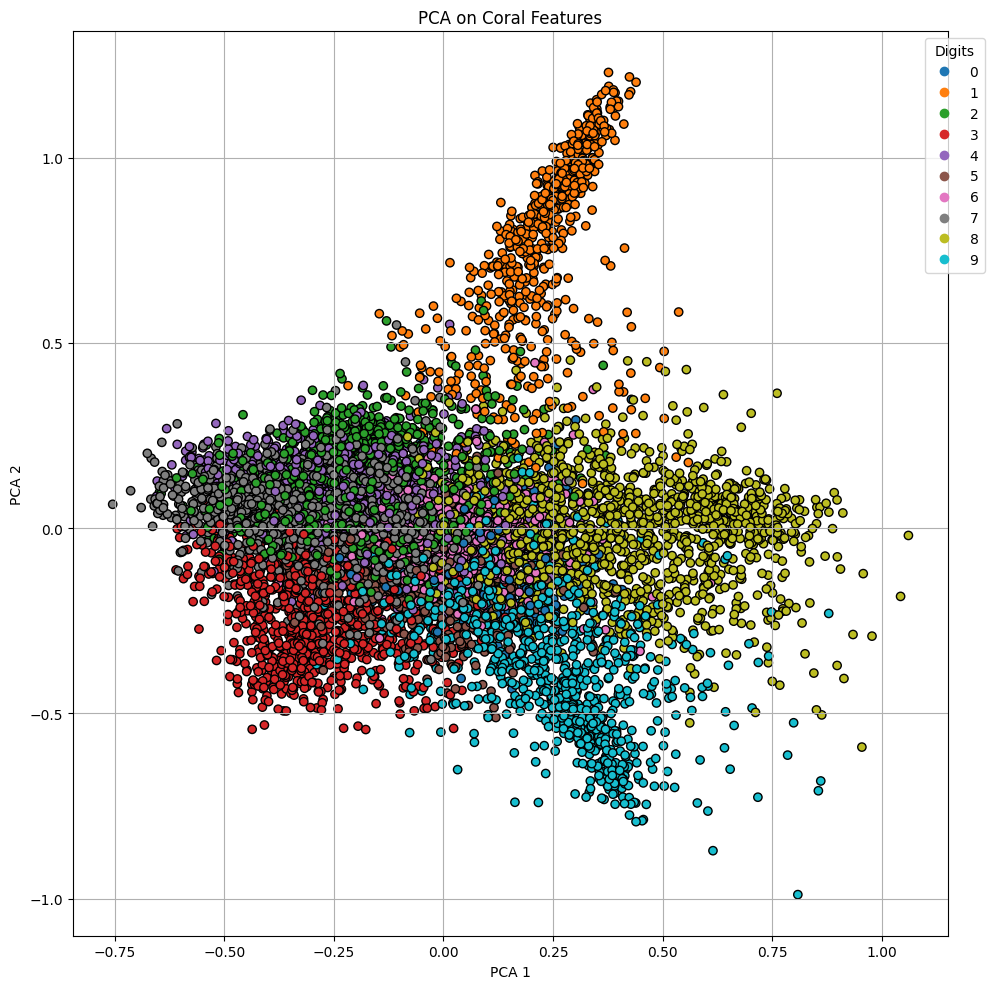

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
features = target_features_mmd
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_pred_mmd, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("PCA on Coral Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


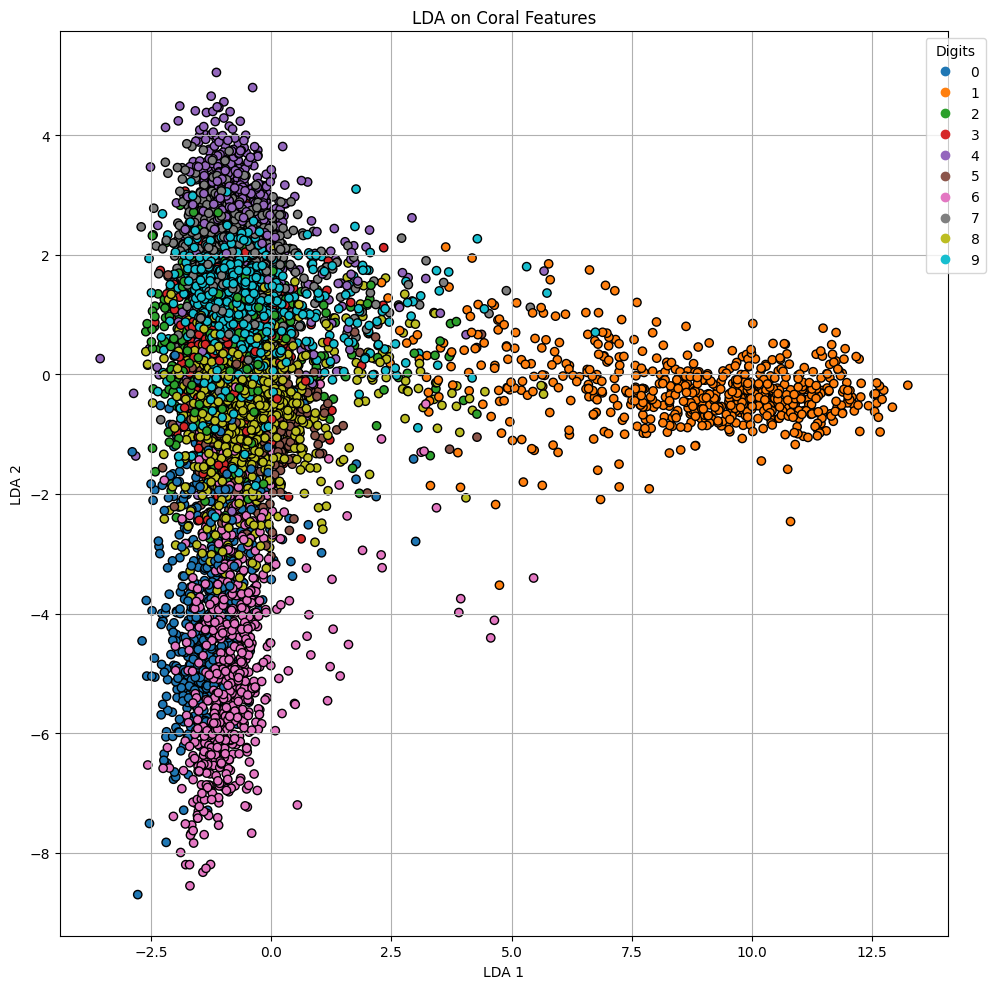

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
lda_result = lda.fit_transform(features, y_pred_mmd)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(lda_result[:, 0], lda_result[:, 1], c=y_pred_mmd, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("LDA on Coral Features")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\anshb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


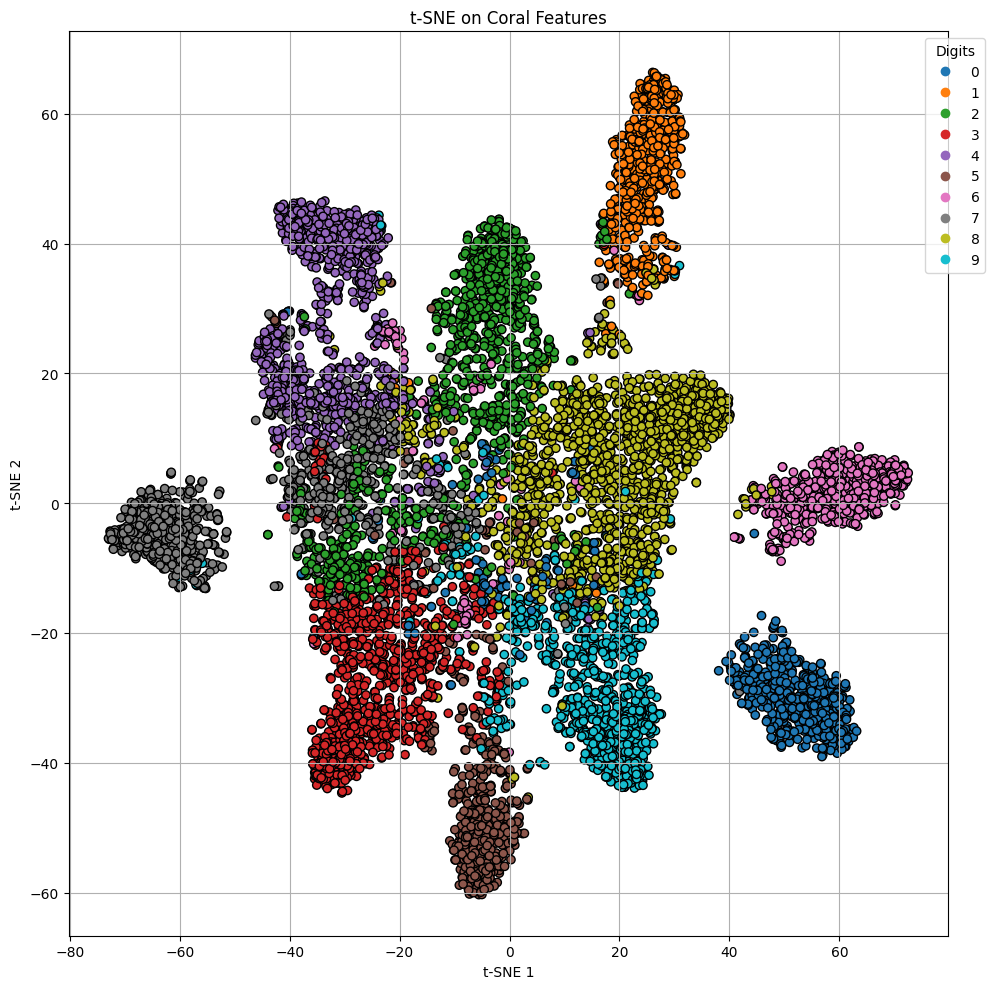

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_pred_mmd, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("t-SNE on Coral Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


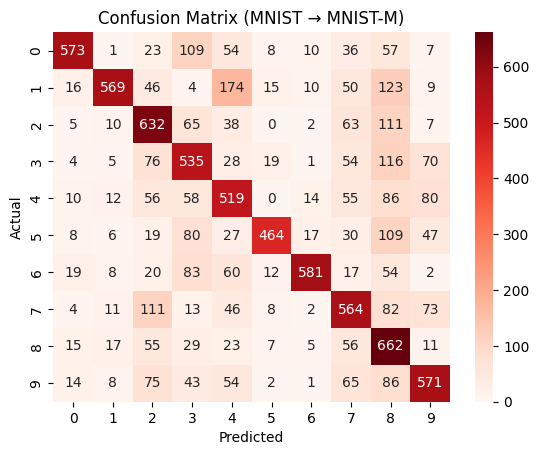

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if len(y_test_m.shape) > 1:
    y_test_m_labels = np.argmax(y_test_m, axis=1)
else:
    y_test_m_labels = y_test_m

if len(y_pred_coral.shape) > 1:
    y_pred_coral_labels = np.argmax(y_pred_coral, axis=1)
else:
    y_pred_coral_labels = y_pred_coral

cm = confusion_matrix(y_test_m_labels, y_pred_coral_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (MNIST → MNIST-M)")
plt.show()


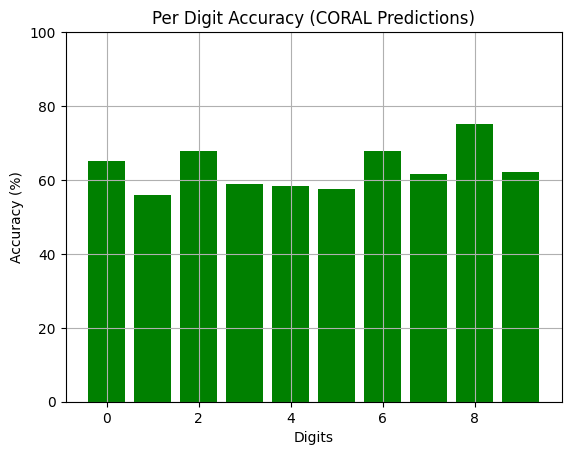

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_true = np.argmax(y_test_m, axis=1)
y_pred = y_pred_coral  

accuracies = []
for digit in range(10):
    idx = (y_true == digit)
    correct = (y_pred[idx] == digit).sum()
    total = idx.sum()
    accuracies.append(correct / total * 100)

plt.bar(range(10), accuracies, color='green')
plt.xlabel("Digits")
plt.ylabel("Accuracy (%)")
plt.title("Per Digit Accuracy (CORAL Predictions)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()


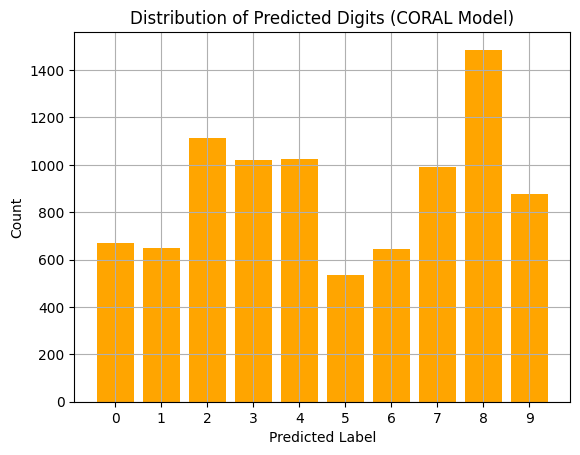

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

if len(y_pred_coral.shape) > 1:
    y_pred = np.argmax(y_pred_coral, axis=1)
else:
    y_pred = y_pred_coral  

plt.hist(y_pred, bins=np.arange(11) - 0.5, rwidth=0.8, color='orange')
plt.xticks(range(10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Distribution of Predicted Digits (CORAL Model)")
plt.grid(True)
plt.show()
